# Coupling of EM Energy: Plane Wave & Two-Wire Transmission Line in Time Domain

The coupling of Electromagnetic energy to a transmission line (TL) is a quite interesting problem. One can think of different applications where it is important to understand or at least get a feeling of how much energy is transfered into a system via TL's; [Counter-drones](https://apelc.com/high-power-wideband-for-counter-uav-uas/) systems is one of them. Imagine a cheap commercial drone adapted to create havoc in enemy territory. 

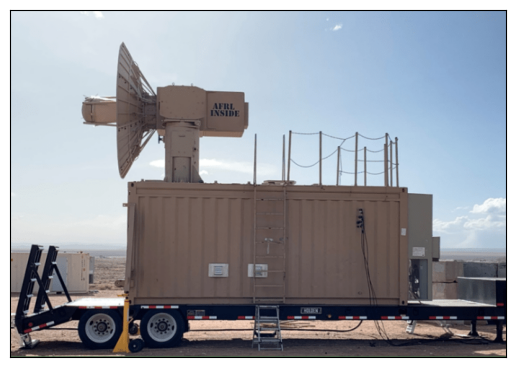

In [11]:
from PIL import Image
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = "https://i0.wp.com/apelc.com/wp-content/uploads/2023/05/1.png?w=688&ssl=1" 
response = requests.get(image_path)
img = np.array(Image.open(io.BytesIO(response.content)).convert('RGB')) #mpimg.imread(image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(img)
response.close()

**<figcaption align = "center"> &uarr;Counter drone system, image <a href="https://apelc.com/high-power-wideband-for-counter-uav-uas/">source </a>&uarr;</figcaption>**

## The system:

In this kind of situation, a cheap commercial drone is probably not the most EM hardened system (i.e. a system that is designed to withstand negative effects of EM energy coming from the outside world), thus every cable is susceptible to pick-up some EM energy sent its way. 

One way to start tackling this problem is to simplify our *system* to the most basic TL problem: a two-wire TL in free space:

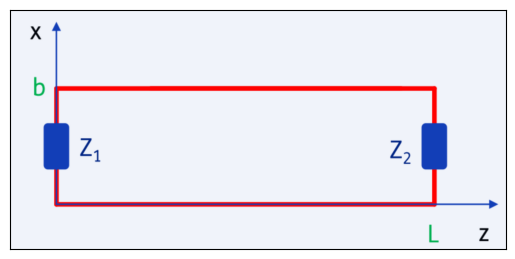

In [32]:
image_path = "./Images/TL.png" 
img = np.array(Image.open(image_path)) 
plt.xticks([])
plt.yticks([])
plt.imshow(img)

**<figcaption align = "center"> &uarr; Schematic of a two-wire TL &uarr;</figcaption>**

In this case, the loads connected at the ends of the TL represent anything, from an electric motor to a transistor in the driver of the motor, or a battery and the equivalent impedance that the whole circuit board *presents* at its power pins, etc., you get the idea. An important simplification from here on is our interest on the so called *differential* mode current; at a difference from the *common* mode and a purely TEM propagation, the differential model will not radiate (or scatter) energy back to the environment (we will assume that the distance between conductors, ***b*** is sufficiently small respect to both the shortest wavelength of interest and the the length of the TL, ***L***. 

## The source:

Once we have defined our system, lets have a look at our sources of EM. In our hypothetical situation, we will be interested in disrupting the drone as far as possible from us (hundreds of m, if not a couple of km), thus is it not unreasonable to assume that any source we have available will radiate energy that when reaching the drone will be characterized by a plane wave behaviour. We will also neglect the presence of the ground, trees and other potential disruptions to our source of EM energy. 

What's more interesting, we want to be able to analyze or choose from different options in the realm of Directed Energy (DE) sources, one such source is the JOLT system developed at the Air Force Research Laboratory (AFRL), which produces a massive, ultra-fast and directed pulse of several hundreds of kV/m at a few meters distance from it: 


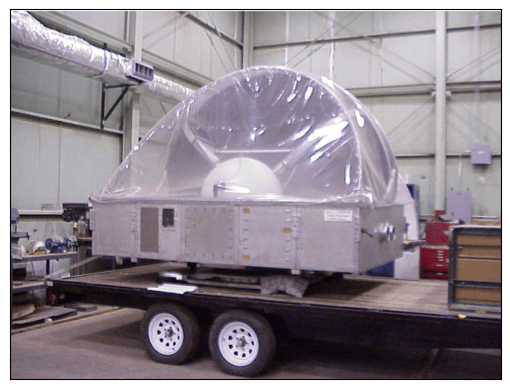

In [12]:
image_path = "https://i0.wp.com/apelc.com/wp-content/uploads/2023/05/2.png?w=648&ssl=1" 
response = requests.get(image_path)
img = np.array(Image.open(io.BytesIO(response.content)).convert('RGB')) #mpimg.imread(image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(img)
response.close()

**<figcaption align = "center"> &uarr;JOLT system, image <a href="https://apelc.com/high-power-wideband-for-counter-uav-uas/">source </a>&uarr;</figcaption>**

The JOLT waveform (that we will see later on) is one of many possible types of waveforms, with different characteristics. These have been compiled and characterized quite completely in reference \[2\].  

Now I have briefly given the *what* and the *why*; from here on we focus on the how: how to compute the energy or simply the current flowing through the loads connected to a two-wire TL given that they are hit by a plane wave whose energy is packed in a pulse-like waveform.

More sofisticated modeling techniques exist to get more details of this interaction right, no doubt! But, this seems like a sensible way to get the ball rolling.

## Computation of induced currents on a two wire transmission line:
In this notebook we compute the induced currents on a two wire transmission line, using the BLT equation [1]. 
As source of field we use a plane wave with a waveform that has been digitized from the work in ([2] and the citations within). The waveform is interpolated to a desired time grid, it is also windowed and padded in time before computing the response of the TL.

See references at the end of this notebook.


In [13]:
import numpy as np
import vector
import scipy 
from scipy.integrate import quad 
import matplotlib.pyplot as plt
import pandas as pd

import sys

Apart from basic well known math./stats/ML libraries, I will also use a library (under development) that I call [EM Basics](https://github.com/deweatherman/EM_Basics), where I compile a few core functions related to definitions connecting waveforms, vector fields, etc.
Once you have the code, you can include its functionality by adding the path to your respective location.

In [14]:
sys.path.append('../EM_Basics/core')  # Add the location of EM_basics/core here.
import Sources as Sources
import Waveform_Basics as Waveform_basics

# Append path to plane wave time domain data:

pathToData = 'Data/'

In [15]:
# Useful constants:

from scipy.constants import mu_0 as mu0                  # H/m          
from scipy.constants import epsilon_0 as eps0            # F/m        
from scipy.constants import c                            # m/s
from scipy.constants import physical_constants 
eta0 = physical_constants['characteristic impedance of vacuum'][0]   #Ohm


print('Permeability of free space: ', mu0)
print('Permitivity of free space: ', eps0)
print('Velocity of propagation in free space: ', c)
print('Characteristic impedance of vacuum: ', eta0)


Permeability of free space:  1.25663706212e-06
Permitivity of free space:  8.8541878128e-12
Velocity of propagation in free space:  299792458.0
Characteristic impedance of vacuum:  376.730313668


## Waveform
In order to obtain the data for waveform from the JOLT system (simulated at 10m distance), I just used a digitazing [app](https://apps.automeris.io/wpd4/) that takes a plot as input and produces a .csv file with the values for time and fields. I pre-processed the file (not the data), so that I get a nice Pandas dataframe format.
Finally I use functionality from the EM Basics library to load the data. Much of the pre-processing I applied here is nicely summarized in reference \[2\].

In [16]:
# Source:
array = Waveform_basics.waveForm.from_time_csv(pathToData+"A3_3_pandas.csv", 1.0, 1.0)

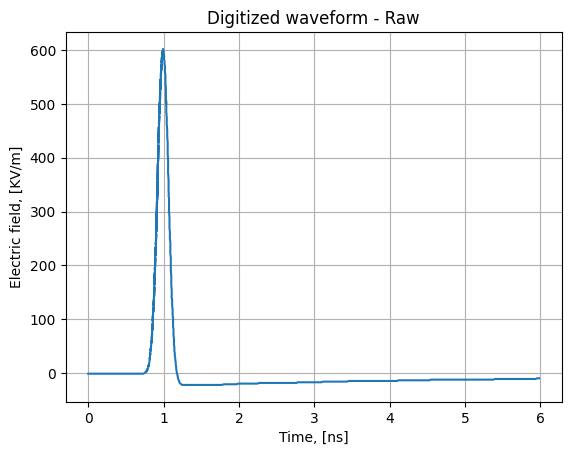

In [27]:
# Plot source: Set start of signal to t=0 for simplicity in analysis

time_s = (array.time[:]-array.time[0])  # Check units of your source plot
E_volt = array.amplitude  # Check units of your source plot
plt.plot(time_s/(1e-9),E_volt/(1e3))
plt.xlabel('Time, [ns]')
plt.ylabel('Electric field, [KV/m]')
plt.title('Digitized waveform - Raw')
plt.grid(True)


The noise present in the image that was digitized, plus the algorithm used by the digitizer app, generates a non uniform sampling rate. A simple way to get a regular grid is to interpolate our signal.


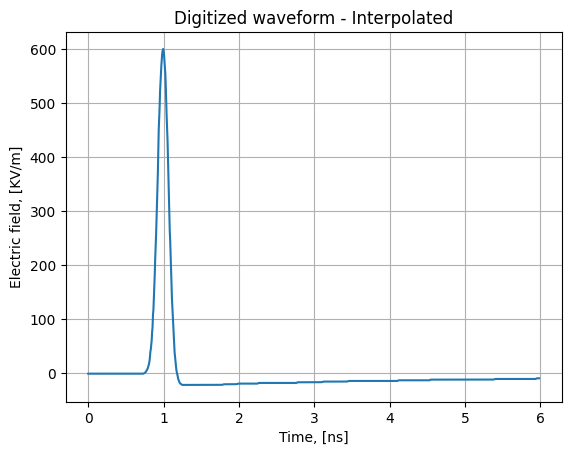

In [28]:
# Interpolate source in time domain (resample to a regular grid):
time_s_interp, E_volt_interp = array.interpolateSignal(1024)
time_s_interp = (time_s_interp[:]-time_s_interp[0])  # Set start time of signal to zero for simplicity
plt.plot(time_s_interp/(1e-9) , E_volt_interp/(1e3))
plt.xlabel('Time, [ns]')
plt.ylabel('Electric field, [KV/m]')
plt.title('Digitized waveform - Interpolated')
plt.grid(True)

Because the signal is digitized from a paper, where measurements are reported, there is a high chance that the waveforms do not start and end neatly at zero; this is undesired given the back and forth between time and frequency domain that we will use later on to compute the currents.

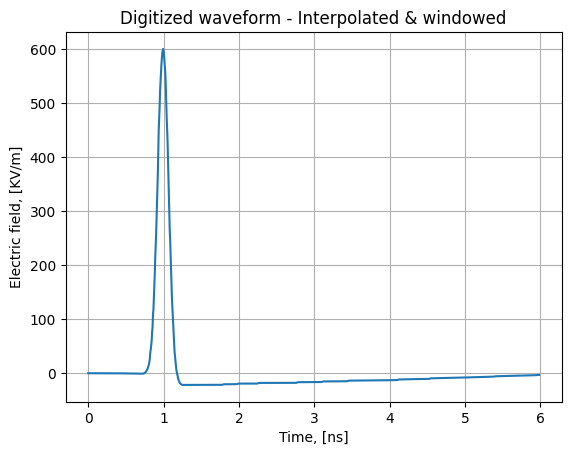

In [29]:
# Windowing digitized signal:
#ta-tb = FWHM
#td = 10 to 90 % rise-time
#tf = 90 to 10 % fall-time"""

ta = 5.5e-9   
tb = 0.5e-9  
td = 0.25e-9
tf = 3e-9

E_volt_interp_w = E_volt_interp*Waveform_basics.uerf(time_s_interp,ta,tb,td,tf) # in case windowing is necessary
plt.plot(time_s_interp/(1e-9) , E_volt_interp_w/(1e3))
plt.xlabel('Time, [ns]')
plt.ylabel('Electric field, [KV/m]')
plt.title('Digitized waveform - Interpolated & windowed')
plt.grid(True)

In order to compute the current flowing in the loads connected to the TL, we start in the time domain, convert to the frequency (Fourier) domain, compute in the frequency domain using the BLT equation and finally convert back (invert) to the time domain. As we will see, our plane wave will induce travelling waves on the TL, these waves flow back and forth between the loads, until their energy is disipated. This makes it so that the response of the system in time, needs simply more time to be completely captured; we reach this objective by adding extra time to the input signal (padding with zeroes), so that the system's response can be recorded also at a late time.

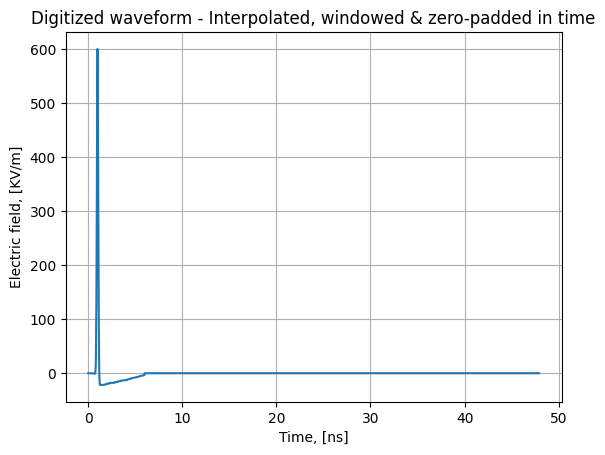

In [30]:
# Padding with zeroes in time
ntotpad = 8192
E_volt_interp_w_pad = np.pad(E_volt_interp_w, 
                             (0, ntotpad - len(E_volt_interp_w)%ntotpad), 
                             'constant')
delta_t = time_s_interp[1]-time_s_interp[0] 
time_interp_w_pad = np.arange(ntotpad)*delta_t
plt.plot(time_interp_w_pad/(1e-9), E_volt_interp_w_pad/(1e3))
plt.xlabel('Time, [ns]')
plt.ylabel('Electric field, [KV/m]')
plt.title('Digitized waveform - Interpolated, windowed & zero-padded in time')
plt.grid(True)

In [21]:
# Resolution in frequency (MHz):
(1/(delta_t*ntotpad))/(1e6)

np.float64(20.864879976705456)

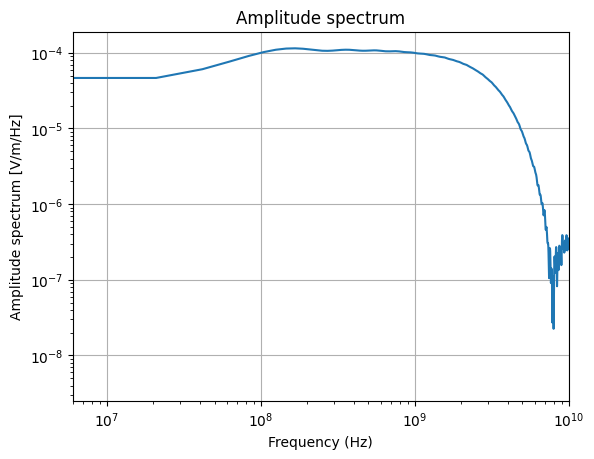

In [31]:
# Get fft of padded signal and plot the positive part of the spectrum:
fft_E = np.fft.rfft(E_volt_interp_w_pad, norm = "backward")
spd_E = (fft_E)*(delta_t*ntotpad)/(ntotpad) # fft_e/delta_f = (fft_E)*(delta_t*ntotpad), finally we normalize according to Parseval's theorem.
freq = np.fft.fftfreq(ntotpad, d=delta_t)
idx = np.argsort(freq)
plt.xscale("log")
plt.yscale("log")
plt.xlim(6e6, 1e10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude spectrum [V/m/Hz]')
plt.title('Amplitude spectrum')
plt.grid(True)
plt.plot(freq[0:int(ntotpad/2)], np.abs(spd_E[0:int(ntotpad/2)]))


## Lets define our incident plane wave:

The impinging plane wave is defined as follows:


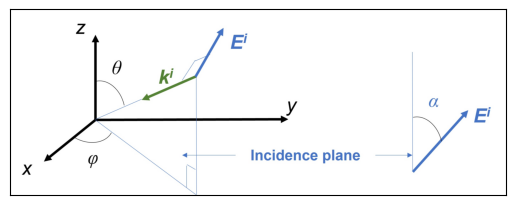

In [33]:
image_path = "./Images/impingingPlaneWaveDef.JPG" 
img = np.array(Image.open(image_path)) 
plt.xticks([])
plt.yticks([])
plt.imshow(img)

**<figcaption align = "center"> &uarr; Definition of the impinging plane wave &uarr;</figcaption>**

**Note from [Vector](https://github.com/scikit-hep/vector) library and coordinates:**

For 3D vectors (e.g. $(E_x, E_y, E_z)$), the angles in [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) are defined as follows:

- $\varphi$ (aka azimuthal), angle between the projection of *vector* on the $xy$ plane and the $x$ axis: **phi**
- $\theta$ (aka polar), angle between *vector* and $z$ axis: **theta**
- $r$ (aka *radial distance*), distance to origin ($\rho$ = $r$*$sin(\theta)$): implemented via **rho**

In [34]:
# Impinging plane wave:

E0Inc = 1        # RMS value of the field intensity, V/m

#Incidence:
# Note for user:
# If thetaIn = 0 or 180, the polarization of E is simplt associated to 
# the azimuthal angle phiIn (alphaIn is not used, cause is undefined).

thetaIn = 45.0      # Degrees, 
phiIn = -45.0        # Degrees
alphaIn = 45.0      # Degrees


# Impinging field derived quantities

thetaInRad = thetaIn*np.pi/180     # 0 < thetaIn< 180
phiInRad = phiIn*np.pi/180
alphaInRad = alphaIn*np.pi/180

## BLT definitions:

I used reference \[1\] to get the BLT formulation, specially Apendix A gives all the details needed.
There are probably some differences in naming, also, the TL there is oriented in *x* and the transverse direction to the wires is *z*. Here it is the opposite. 


In [48]:
# Tesche's formulation:

# alongTLsource1: response at node 1
# Term to be integrated along the direction of the TL (e.g. on z).
# Here only the longitudinal component is considered (e.g. z, if the TL is directed on z)
def alongTLsource1(z, incPw, b, y, gamma_):
    '''
    Computes effect on load 1 of distributed field excitation at one point (z) of the TL.

    Details: Effectively implements the integrand of the first term in the first row 
    of the right hand side in equation (A5) of reference [1] (there TL on x, here TL on z).

    Parameters:
        z (float): positive distance z from the reference z=0.
        incPw (vector object): incident plane wave.
        b (float): separation between wires of the two-wire TL.
        y (float): y coordinate of the TL (TL is contained in xz plane).
        gamma_ (complex): propagation constant of the TL (alpha+j*beta).

    Returns:
        complex: difference transverse field between upper and lower wires (accounting for phase shift towards load 1).

    '''
    
    obsx_b = vector.obj(x = b, y = y, z = z)
    obsx_0 = vector.obj(x = 0, y = y, z = z)
    K_z_omega = incPw.obsEField(obsx_b).z - incPw.obsEField(obsx_0).z

    vOnLoad1 = K_z_omega*( np.exp(gamma_*z) )
    
    return vOnLoad1 


# alongTLsource2: response at node 2
# Term to be integrated along the direction of the TL (e.g. on z).
# Here only the longitudinal component is considered (e.g. z, if the TL is directed on z)
def alongTLsource2(z, incPw, b, y, gamma_, L):
    '''
    Computes effect on load 2 of distributed field excitation at one point (z) of the TL.

    Details: Effectively implements the integrand of the first term in the first row 
    of the right hand side in equation (A5) of reference [1] (there TL on x, here TL on z).

    Parameters:
        z (float): positive distance z from the reference z=0.
        incPw (vector object): incident plane wave.
        b (float): separation between wires of the two-wire TL.
        y (float): y coordinate of the TL (TL is contained in xz plane).
        gamma_ (complex): propagation constant of the TL (alpha+j*beta).
        L (float): total length of TL.

    Returns:
        complex: difference transverse field between upper and lower wires (accounting for phase shift towards load 2).

    '''    
    obsx_b = vector.obj(x = b, y = y, z = z)
    obsx_0 = vector.obj(x = 0, y = y, z = z)
    K_z_omega = incPw.obsEField(obsx_b).z - incPw.obsEField(obsx_0).z

    vOnLoad2 = K_z_omega*( np.exp(gamma_*(L-z)) )
    
    return vOnLoad2

def acrossTLsource(x, incPw, y, z):
    '''
    Computes transverse component of field excitation at one point (z) of the TL.

    Parameters:
        z (float): positive distance z from the reference z=0.
        incPw (vector object): incident plane wave.
        b (float): separation between wires of the two-wire TL.
        y (float): y coordinate of the TL (TL is contained in xz plane).

    Returns:
        complex: transverse component of field excitation at one point (z) of the TL.

    '''       
    obsz_0 = vector.obj(x = x, y = y, z = z)
    return incPw.obsEField(obsz_0).x



def calculate_induced_current(f, gamma_, phiInRad, thetaInRad, 
                              EIncVector, L, b, x0, y0, z0, 
                              rho1, rho2,):
    '''
    This function computes the currents induced on the loads connected at the extremes of the 
    TL; we use the BLT equation for this, see reference [1].

    Parameters:
        f (float, array): array of frequencies.
        phiInRad (float): azimuthal angle phi in radians (incidence direction).
        thetaInRad (float): polar angle theta in radians (incidence direction).
        EIncVector (float): amplitude of incident plane wave.
        b (float): separation between wires of the two-wire TL.
        x0 (float), y0 (float), z0 (float): reference point of one the conductors of the TL.
        rho1 (float): voltage reflextion coefficient at load 1
        rho2 (float): voltage reflextion coefficient at load 2

    Returns:
        complex: transverse component of field excitation at one point (z) of the TL.

    '''      
    
    omega_ = 2*np.pi*f    # rad/s
    wavenumber = omega_*np.sqrt(mu0*eps0)
    waveVector = vector.obj(phi = phiInRad, 
                            theta = thetaInRad, 
                            rho = -1*wavenumber*np.sin(thetaInRad)) # Ingoing wave (therefore directed towards -1.0*rho)
    incPw = Sources.planeWave(EIncVector, waveVector)    # Plane wave definition

    # Inverted incidence matrix: manually inverted incidence matrix (middle inverse matrix in eq. (A4))
    eGammaL = np.exp(gamma_*L)
    eGammaLInv = 1.0/eGammaL
    w = 1.0/(eGammaL-rho1*rho2*eGammaLInv)
    invertedIncidentMatrix = w*eGammaLInv*np.matrix([[rho2, (rho1*rho2*eGammaLInv+1/w)], 
                                                    [eGammaL, rho1]])

    # First term of right hand side, first row eq. (A5):
    # int( (Ez_inc(z,b)-Ez_inc(z,0))*exp(gamma*z) , dz)
    S11, _ = quad(alongTLsource1, z0, L, args=(incPw, b, y0, gamma_), complex_func=True)

    # First term of right hand side, second row eq. (A5):
    # int( (Ez_inc(z,b)-Ez_inc(z,0))*exp(gamma*(L-z)) , dz) 
    S21, _ = quad(alongTLsource2, z0, L, args=(incPw, b, y0, gamma_, L), complex_func=True)

    # Lumped sources at the ends of the TL: result from field components on the transversal direction
    vSource1, _ = quad(acrossTLsource, x0, b, args=(incPw, y0, z0), complex_func=True)
    vSource2, _ = quad(acrossTLsource, x0, b, args=(incPw, y0, L), complex_func=True)

    # Assemble S terms of [S]
    S12 = vSource1
    S13 = vSource2*np.exp(gamma_*L)
    S22 = vSource1*np.exp(gamma_*L)
    S23 = vSource2

    # Equation (A5):
    S1 = 0.5*(S11 + S12 - S13)
    S2 = 0.5*(-1.0*S21 - S22 + S23)
    S = np.array([[S1],[S2]])

    # BLT for voltages:
    # reflectivityMatrix = np.matrix([[1.0 + rho1, 0.0], [0.0, 1.0 + rho2]])
    # V = (reflectivityMatrix.dot(invertedIncidentMatrix)).dot(S)

    # BLT for currents:
    reflectivityMatrix_I = np.matrix([[1.0 - rho1, 0.0], [0.0, 1.0 - rho2]])
    I_BLT = 1/(Z0)*(reflectivityMatrix_I.dot(invertedIncidentMatrix)).dot(S)
        
    I0 = I_BLT[0,0] #V[0,0]/Z1
    IS = I_BLT[1,0] #V[1,0]/Z2
        
    return I0, IS 



# Definition of parameters of the transmission line and loads:
Our transmission line is formed by two wires with radius $a$, separated a distance $b$ and with a total length $L$:

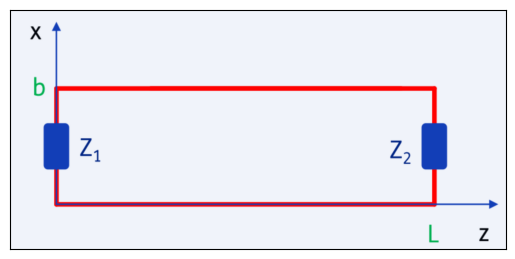

In [26]:
image_path = "./Images/TL.png" 
img = np.array(Image.open(image_path)) 
plt.xticks([])
plt.yticks([])
plt.imshow(img)

For simplicity, in this example the loads are purely resistive. But the code is easily usable for frequency-dependent impedances.

In [36]:
# TL (two wire) dimensions:
# This transmission line is directed in z,
# while the vector from one conductor to the other
# is directed in x

b = 3e-3  # Separation between conductors, [m]
L = 100e-2     # Lenght of the TL             , [m]
a = 0.5e-3

# Loads
Z1 = 0    # load on z = 0, [Ohm]
Z2 = 100     # load on z = L, [Ohm]

y0 = 0  # This TL is contained in the xz plane y = 0.
x0 = 0  # First wire of TL is located in x = 0
z0 = 0  # This TL is directed along hat(z) and starts in z = 0

# Two wires transmission line, 
# characteristic impedance Z0:
Z0 = 120*np.log(2*b/a)    

# Voltage reflection coefficients:
rho1 = (Z1-Z0)/(Z1+Z0)
rho2 = (Z2-Z0)/(Z2+Z0)

# Computing currents:
In the next block, we compute the induced currents in the frequency domain; after this we convert back to the time domain via the inverse fft.

In [50]:
# Tesche implementation: with multiprocessing
import time

import itertools
import multiprocessing

# Assemble EIncVector from linearly polarized planewave definition:
EIncVector = Sources.linPolEField(E0Inc, thetaInRad, phiInRad, alphaInRad)  

# Prepare empty lists to append intermediate results:
TF_S = []
TF_0 = []
IS_list = []
I0_list = []

tic = time.perf_counter()

# We will solve the current for the positive frequencies;
# then we use the ifft for real signals (like ours) 
# to compute the currents back in time domain:
f = freq[0:int(ntotpad/2)]

# TL dependent parameters:
alpha = 0.0
beta = 2*np.pi*f/c
gamma_ = alpha+1.0j*beta  

paramlist = list(zip(f, gamma_, 
                     itertools.repeat(phiInRad),
                     itertools.repeat(thetaInRad),
                     itertools.repeat(EIncVector),
                     itertools.repeat(L),
                     itertools.repeat(b),
                     itertools.repeat(x0),
                     itertools.repeat(y0),
                     itertools.repeat(z0),
                     itertools.repeat(rho1),
                     itertools.repeat(rho2)))

pool = multiprocessing.Pool(10)

I0, IS = zip(*pool.starmap(calculate_induced_current,paramlist, chunksize=50))

# Scale components accordingly in frequency domain:
waveform = fft_E[0:int(ntotpad/2)]  #  Waveform in frequency domain
I0_np = np.asarray(I0)*waveform
IS_np = np.asarray(IS)*waveform

# Get irfft of current (time domain thus):
inv_fft_pad_S = np.fft.irfft(IS_np, n=ntotpad)
inv_fft_pad_0 = np.fft.irfft(I0_np, n=ntotpad)



toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

/home/mario/anaconda3/envs/emBasics/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:441: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/home/mario/anaconda3/envs/emBasics/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:444: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singulari

Finished in 287.8367 seconds


Finally we visualize the induced currents (on the load S) and the incident field in the time domain:

## Visualization of response of the TL:
Now we plot both the induced current on one of the loads, and the incident plane wave waveform for comparison. From this result one can compute energy/power, etc.

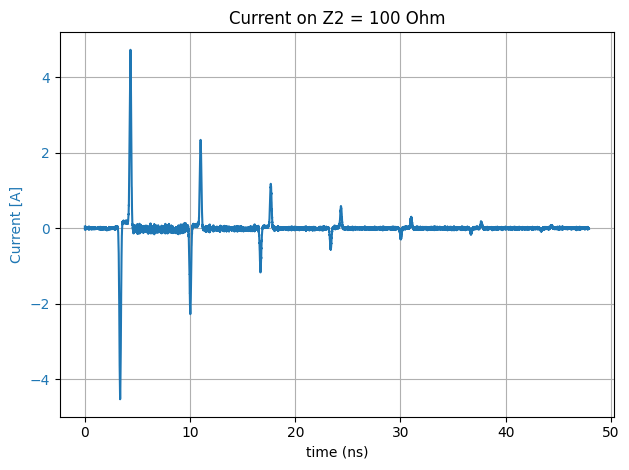

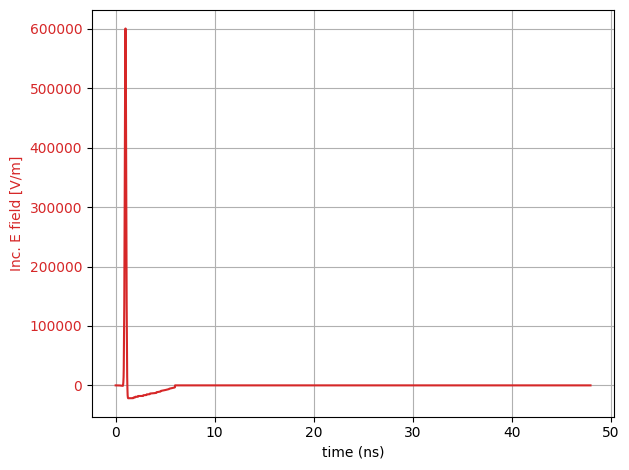

In [52]:
# Plot current and incident field in time domain:

fig1, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time (ns)')
ax1.set_ylabel('Current [A]', color=color)
ax1.set_title('Current on Z2 = 100 Ohm')
ax1.plot(time_interp_w_pad/(1e-9), np.real(inv_fft_pad_S),) 
         #time_interp_w_pad/(1e-9), np.real(inv_fft_pad_S))
ax1.tick_params(axis='y', labelcolor=color)
fig1.tight_layout()
plt.grid(True)
plt.show()

#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

fig2, ax2 = plt.subplots()
color = 'tab:red'
ax2.set_xlabel('time (ns)')
ax2.set_ylabel('Inc. E field [V/m]', color=color)  # we already handled the x-label with ax1
ax2.plot(time_interp_w_pad/(1e-9), E_volt_interp_w_pad, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig2.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
plt.show()

## Concluding remarks:

In this notebook we reviewed the implementation of the BLT equation to compute induced currents due to a plane wave. We used a practical example of computation with a relevant application in mind, and we also reviewed the basic assumptions behind the simplifications made.

We did not go into the specific limitations of the BLT equation in terms of applicability (e.g. if the wires are separated to much respect to the wavelenght, etc.); neither we discussed the effects of neglecting the effects of dielectrics surrounding the lines or the structure of the drone, nor the fact that wires in a drone have bends and more complex distributions than simple straight wires. 

It is however relevant to have this basic model at hand, as it allows one to explore potential routes of analysis for more complex systems; it also allows a quick-and-dirty estimation of expected orders of magnitude for simple measurements at the lab.

# References:

[1] F. M. Tesche, C. M. Butler, “On the Addition of EM Field Propagation and Coupling Effects in the BLT Equation” , Carl Baum Notes, Interaction Notes, Note 588, June 2004.

[2] N. Mora, et al., “Study and Classification of Potential IEMI Sources” , Carl Baum Notes, System Design and Assessment Notes, Note 41, July 2014.